In [1]:
import sqlite3
import pandas as pd

con = sqlite3.connect('mon_reddit.sqlite')
df = pd.read_sql_query('SELECT * from posts;', con)
con.close()
df

,title,link,author,n_comments,score,text
0,"The r/Mongolia 50,000 subscriber milestone survey",/r/mongolia/comments/17cwst9/the_rmongolia_500...,EpochFail9001,12,35,Please take a moment to fill out a quick surve...
1,Help,/r/mongolia/comments/1b5h8ji/help/,Financial-Divide-774,10,50,
2,I can’t stop laughing about the post of the gu...,/r/mongolia/comments/1b5chfv/i_cant_stop_laugh...,AdhesivenessAware670,15,48,Got me thinking what do people actually say? D...
3,I love mongolia,/r/mongolia/comments/1b5o9xo/i_love_mongolia/,Pretend_Display2379,0,3,I’m not mongolian never been to mongolia but I...
4,I find it funny and sad that when I stop for p...,/r/mongolia/comments/1b56yvg/i_find_it_funny_a...,upgrademcr,17,49,"Mongolian drivers are so angry and impatient, ..."
...,...,...,...,...,...,...
951,I think we are evolving,/r/mongolia/comments/18pxe35/i_think_we_are_ev...,Cr1spyTM,7,155,
952,Question about currency exchange in UB,/r/mongolia/comments/18qex25/question_about_cu...,jmiragee,2,2,"Hey everyone, I’m travelling to Mongolia in 2 ..."
953,"Laos, Vientiane, something looks similar?",/r/mongolia/comments/18qe789/laos_vientiane_so...,_steppe22,2,0,Vietnamd bs harsan ene neg yg Hangarid sjif ha...
954,Are there less young people?,/r/mongolia/comments/18qcv04/are_there_less_yo...,Antique-Tangerine719,9,0,Does anyone else feel like the amount of young...


# Extract the sentiment scores using keywords sentiment analysis method

First, we use the keyword sentiment analysis method. We start by loading the AFINN file which has a dictionary of words and their corresponding sentiment scores.

In [2]:
sentiment_df = pd.read_csv('AFINN-en-165.txt', sep='\t', names=['word', 'score'], index_col='word')
sentiment_df

,score
word,
abandon,-2
abandoned,-2
abandons,-2
abducted,-2
abduction,-2
...,...
yucky,-2
yummy,3
zealot,-2


Here, we convert our dataframe to a dictionary which will be useful when querying the sentiment scores by the keywords.

In [39]:
sentiment_dict = sentiment_df.to_dict()['score']

Now we can find the average sentiment for each title we have in our original dataframe. We get the scores for each word and take the average for each title.

In [4]:
import numpy as np

title_sentiments = []
for title in df['title']:
    words = title.lower().split()
    this_titles_sentiments = []
    for w in words:
        if w in sentiment_dict.keys():
            this_titles_sentiments.append(sentiment_dict[w])
        else:
            this_titles_sentiments.append(0)
            
    
    title_sentiments.append(np.mean(this_titles_sentiments))

In [5]:
df['keyword_sentiment'] = title_sentiments

# Plot a histogram of the sentiment scores

The histogram below indicates that most of the titles have neutral sentiment score skewing slightly to the positive direction.

<Axes: ylabel='Frequency'>

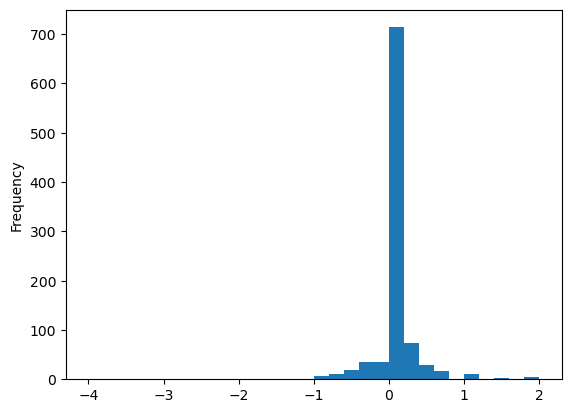

In [6]:
df['keyword_sentiment'].plot.hist(bins=30)

# Look at descriptive statistics of the sentiment scores

The mean and the median are almost zero, while the standard deviation indicates that the dataset is clustered around the mean which is consistent with our graph.

In [7]:
df['keyword_sentiment'].mean()

0.03854881640225097

In [8]:
df['keyword_sentiment'].median()

0.0

In [9]:
df['keyword_sentiment'].std()

0.3091805416748803

# Examine the text for some of the highest and lowest sentiment scores

Here, we can see that the lowest sentiment score is -4 while the highest sentiment score is 2. The lowest sentiment score is further away from the mean which tells us that there are some very negative posts in this subreddit.

In [10]:
df.sort_values(by='keyword_sentiment')[['title', 'keyword_sentiment']]

,title,keyword_sentiment
491,wtf,-4.00
607,NYAMBAATAR SHOULD FUCKING DIE,-1.75
923,Don’t kill me,-1.00
84,homeless people,-1.00
617,Nyambaatar really fucked up,-1.00
...,...,...
48,Popular Opinion,1.50
484,helping,2.00
888,Funny picture,2.00
1,Help,2.00


In [11]:
df.sort_values(by='keyword_sentiment')['title'].to_list()[:10]

['wtf',
 'NYAMBAATAR SHOULD FUCKING DIE',
 'Don’t kill me',
 'homeless people',
 'Nyambaatar really fucked up',
 'my biggest fucking enemy this winter',
 'Visa problems',
 'I Hate Mongolians',
 'Let’s stop this madness pls',
 'Alexei Nalavny has died']

In [12]:
df.sort_values(by='keyword_sentiment', ascending=False)['title'].to_list()[:10]

['help',
 'helping',
 'Funny picture',
 'Help ',
 'Popular Opinion',
 'Good dentist? ',
 'HELP ME',
 'Translation help',
 'I love mongolia',
 'Found him hahaha']

# Extract the sentiment scores of the titles of the posts using TextBlob

Next, we use a python package called TextBlob to analyze sentiment scores. Using Textblob, we can find the polarity (-1 to =1) and subjectivity (0 to 1, objective to subjective) of a string. For example, we can see this sentence below is rated fully subjective and has a positive sentiment.

In [16]:
from textblob import TextBlob

tb = TextBlob("April snowstorms make for some beautiful pictures...")
tb.sentiment

Sentiment(polarity=0.85, subjectivity=1.0)

We apply textblob to the whole dataframe rows like this

In [17]:
def get_tb_sentiment(text):
    tb = TextBlob(text)
    return tb.sentiment[0]

df['tb_sentiment'] = df['title'].apply(get_tb_sentiment)

# Plot a histogram of the sentiment scores

The histogram looks similar to the one using keyword sentiment analysis method skewed slightly towards the positive sentiment.

<Axes: ylabel='Frequency'>

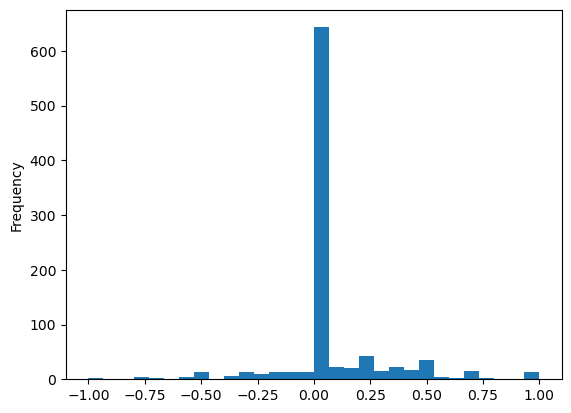

In [19]:
df['tb_sentiment'].plot.hist(bins=30)

# Look at descriptive statistics of the sentiment scores

The descriptive statistics look almost the same as the statistics of the keyword method. This further enforces that the titles have mostly neutral sentiment. Here, the standard deviation is fairly smaller than the deviation of the keyword method which makes sense because the polarity score of textblob has a range between -1 and 1.

In [20]:
df['tb_sentiment'].mean()

0.05828896421502332

In [21]:
df['tb_sentiment'].median()

0.0

In [22]:
df['tb_sentiment'].std()

0.24284689058572728

# Examine the text for some of the highest and lowest sentiment scores

In [44]:
df.sort_values(by='tb_sentiment')[['title', 'tb_sentiment']]

,title,tb_sentiment
476,CMV: Geographically and geopolitically speakin...,-1.0
177,Are there any Sperm donors in Mongolia? seriou...,-1.0
548,Horrifying,-0.9
779,Make me hate these college prep academies,-0.8
714,I Hate Mongolians,-0.8
...,...,...
38,Happy Mongolian Patriots' Day!,1.0
459,What is the best president Mongolia had to thi...,1.0
655,"Hey guys, if you have the time, please answer ...",1.0
278,Which Water Filtration System is the Best in M...,1.0


# Extract the sentiment scores of the titles of the posts using Vader

Finally we use Vader. Vader provides a breakdown of the negative, positive, neutral scores, and an overall score called 'compound'. We can simply use the 'compound' score as our overall sentiment score.

In [24]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores("April snowstorms make for some beautiful pictures...")

{'neg': 0.0, 'neu': 0.606, 'pos': 0.394, 'compound': 0.5994}

In [25]:
analyzer.polarity_scores("April snowstorms make for some beautiful pictures...")['compound']

0.5994

Here we apply our get_vader_sentiment function to each row of our datafram title column.

In [26]:
def get_vader_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)['compound']

df['vader_sentiment'] = df['title'].apply(get_vader_sentiment)

# Plot a histogram of the sentiment scores


<Axes: ylabel='Frequency'>

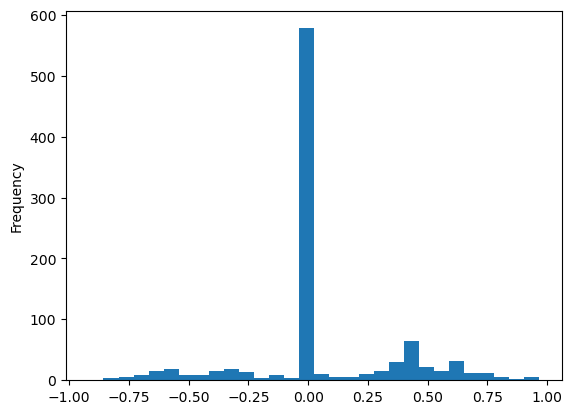

In [29]:
df['vader_sentiment'].plot.hist(bins=30)

# Look at descriptive statistics of the sentiment scores

both the historgram and the descriptive statistics tell the same story as other methods.

In [30]:
df['vader_sentiment'].mean()

0.05788033472803347

In [31]:
df['vader_sentiment'].median()

0.0

In [32]:
df['vader_sentiment'].std()

0.3090389132045557

# Examine the text for some of the highest and lowest sentiment scores

The lowest score is -0.92 while the highest is 0.97. Interestingly, sentiment analysis using vader doesn't have a full value of -1 or 1. This means the analysis is not 100% certain like the other analysis methods. This difference arises from Vader's ability to analyze the overral compound of a sentence, not just keywords.

In [47]:
df.sort_values(by='vader_sentiment')[['vader_sentiment']]

,vader_sentiment
611,-0.9198
453,-0.8343
186,-0.8316
223,-0.8126
860,-0.7906
...,...
225,0.9054
276,0.9136
317,0.9259
372,0.9312
